In [2]:
%%javascript
/*Disable scrollbar in a cell*/

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import os
import SALib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import date
from SAFEpython import PAWN
from SALib.sample import saltelli
from SALib.analyze import sobol, delta
from SAFEpython.util import aggregate_boot
from itertools import combinations, product

# Folder structure
experiment_name = 'ijburg-global-2048'
path = f'../experiments/{experiment_name}/'

# Construct a dictionary of name (key) and titles for plots (value)
names = {'single_utility_at_max': 'Utility at homogeneity (M)',
            'single_optimal_fraction': 'Optimal fraction ($t_i$)', 
#             'radius': 'Radius (r)', 
#             'neighbourhood_mixture': 'Neighbourhood mix (b)',
            'max_move_fraction':'Fraction moved (f)',
            'temperature':'Temperature (T)',
            'homophily_std':'Std. of optimal fraction (s)',
            'alpha': 'Alpha', 
            'school_capacity': 'School capacity (c)',
#             'dummy':'Dummy'
        }
output_names = {
#             'res_seg_new': 'Residential segregation (Theil)',
            'school_seg_new': 'School segregation (Theil)',
#             'res_isolation': 'Residential segregation (Isolation)',
            'school_isolation': 'School segregation (Isolation)'}

renaming = names.copy()
renaming['utility_at_max'] = names['single_utility_at_max']
renaming['optimal_fraction'] = renaming['single_optimal_fraction']
# renaming['max_steps'] = renaming['max_res_steps']

# Construct lists of input columns and outputs to plot
columns_to_plot = list(names.values())
output_to_plot = list(output_names.values())
data = pd.read_pickle(f"{path}data/frame.pkl")

# Rename the columns
data.rename(columns=names, inplace=True)
data.rename(columns=output_names, inplace=True)
parameters = data[columns_to_plot]
output = data[output_to_plot]
# output['School - residential'] = data['School segregation (Theil)'] - \
#     data['Residential segregation (Theil)']
# data['School - residential'] = output['School - residential']

print(data[['res_converged', 'school_converged']].describe())

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/ijburg-global-2048/data/frame.pkl'

# General plot settings

In [4]:
# print(mpl.rcParams.keys)
sns.set(style="whitegrid")
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['grid.alpha'] = 1

# colors = itertools.cycle((',', '+', '.', 'o', '*'))
markers = ('o', 'v', 's', 'd', '<', '+')

# Parameter distributions when residential process is not converged

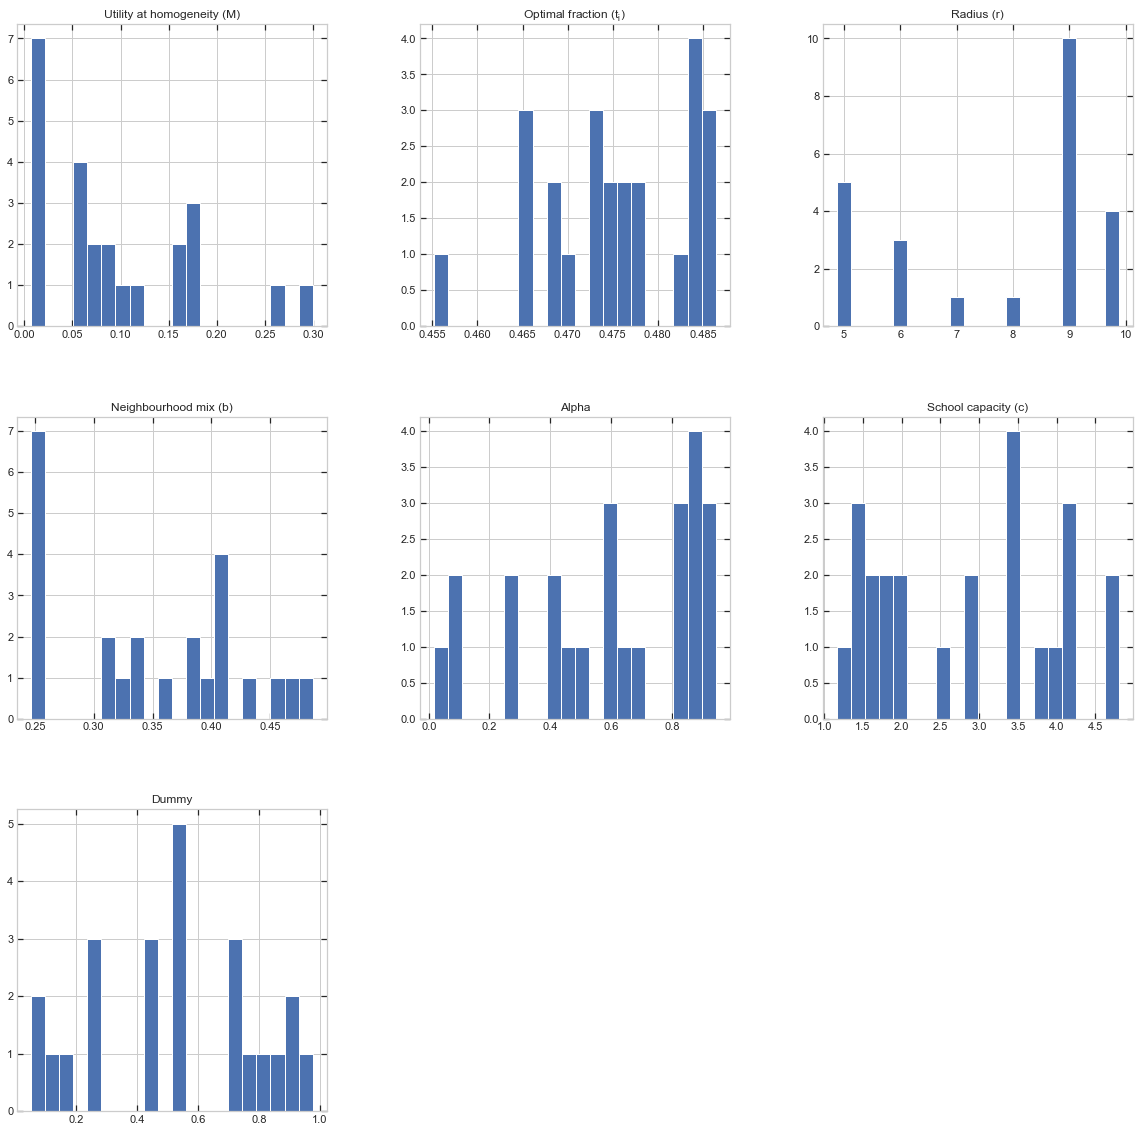

In [5]:
res_not_converged = parameters[data.res_converged==False]
# _ = res_not_converged.hist(figsize=(20,20), align='left', bins=20)

# Parameter distributions when school process is not converged

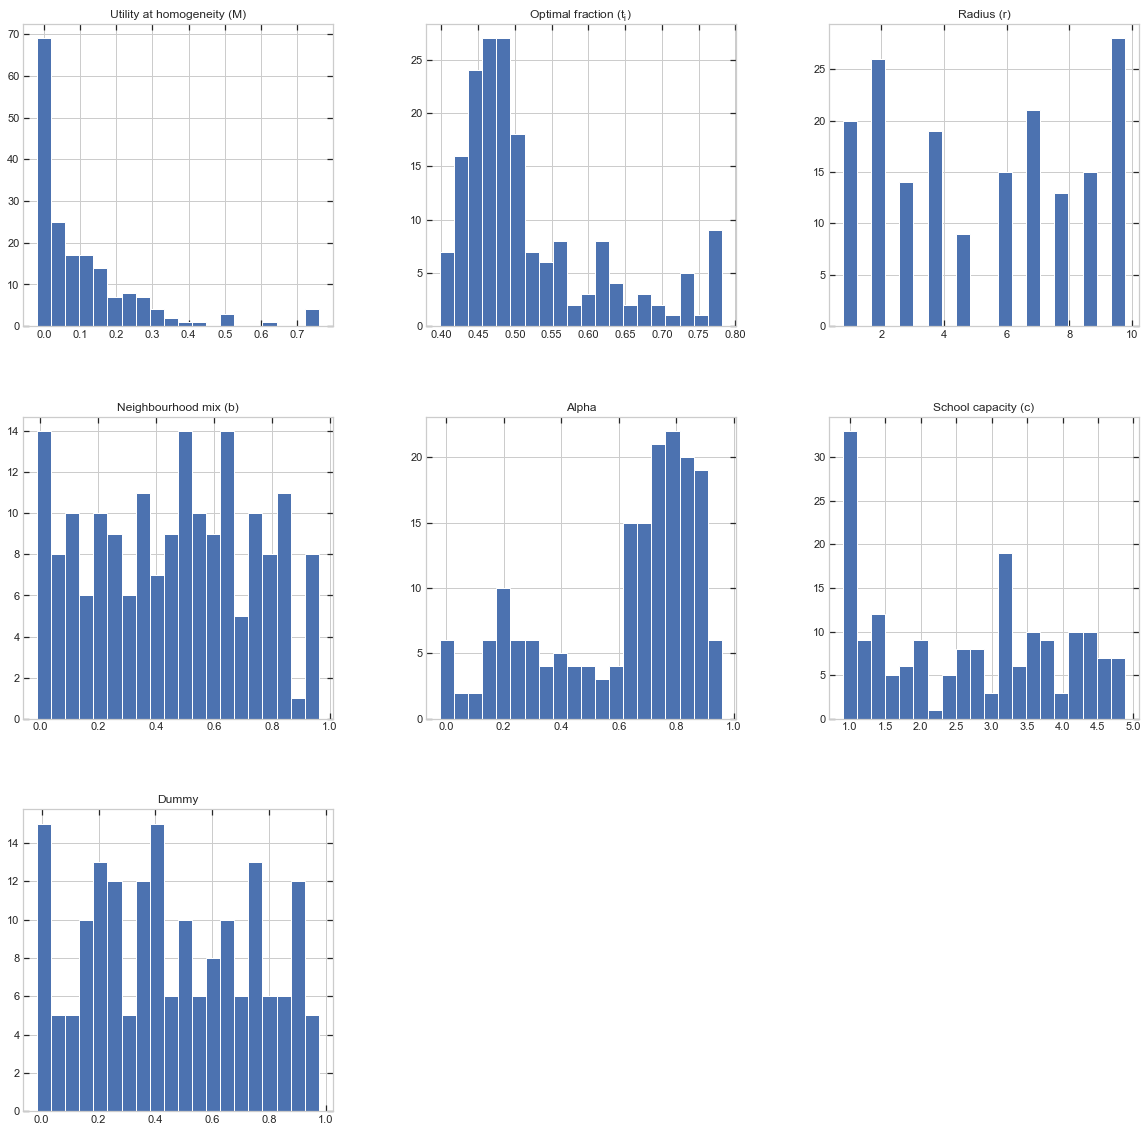

In [6]:
school_not_converged = parameters[data.school_converged==False]
_ = school_not_converged.hist(figsize=(20,20), align='left', bins=20)

# Parameter distributions when residential is fully segregated

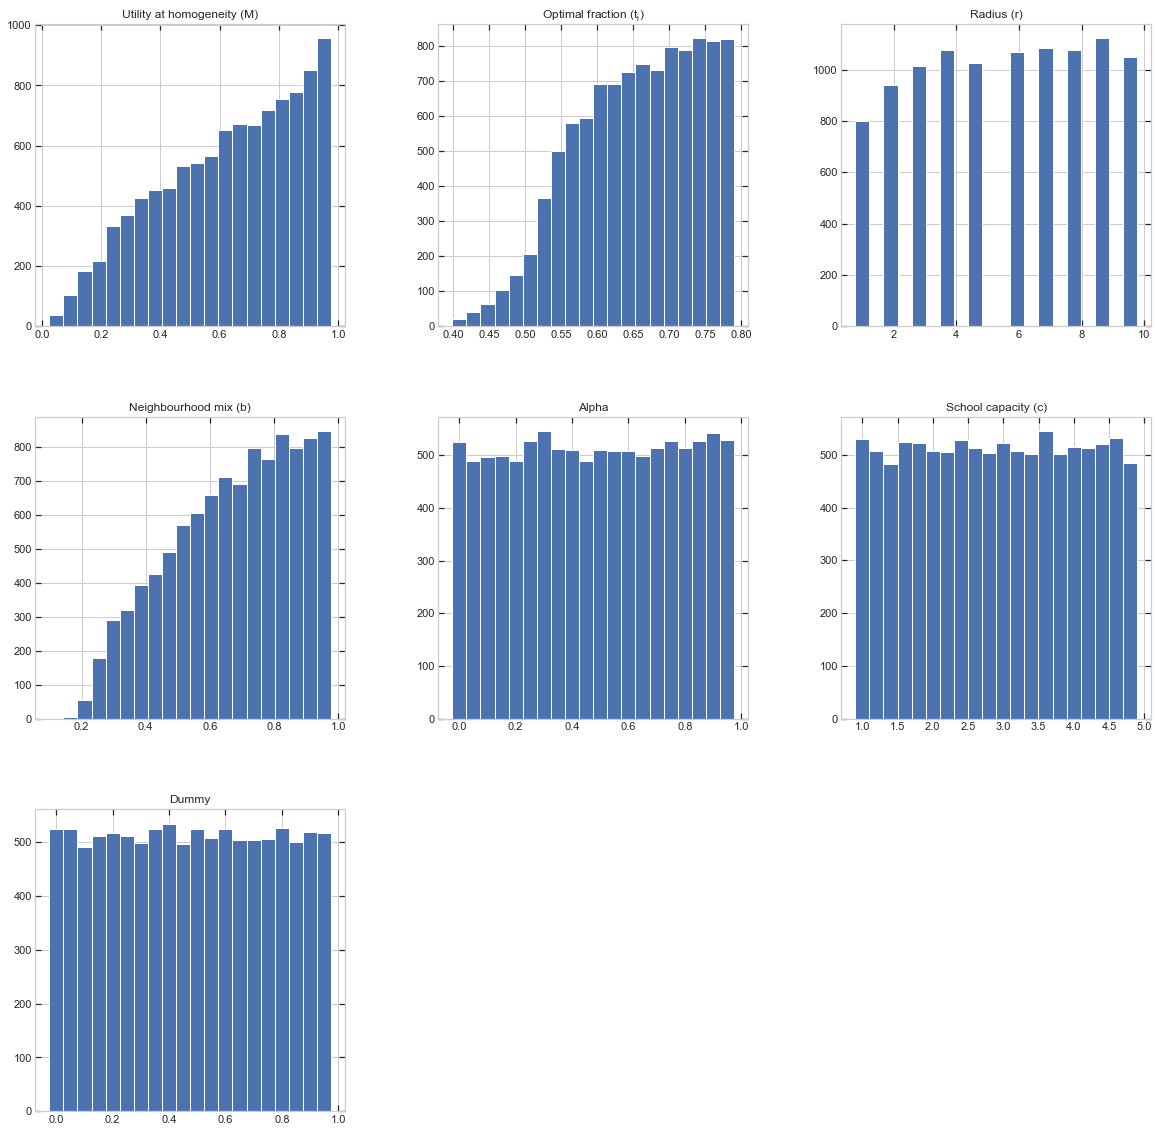

In [7]:
# fully_res = parameters[data['Residential segregation (Theil)']>0.99]
# _ = fully_res.hist(figsize=(20,20), align='left', bins=20)

# Parameter distributions when schools are fully segregated

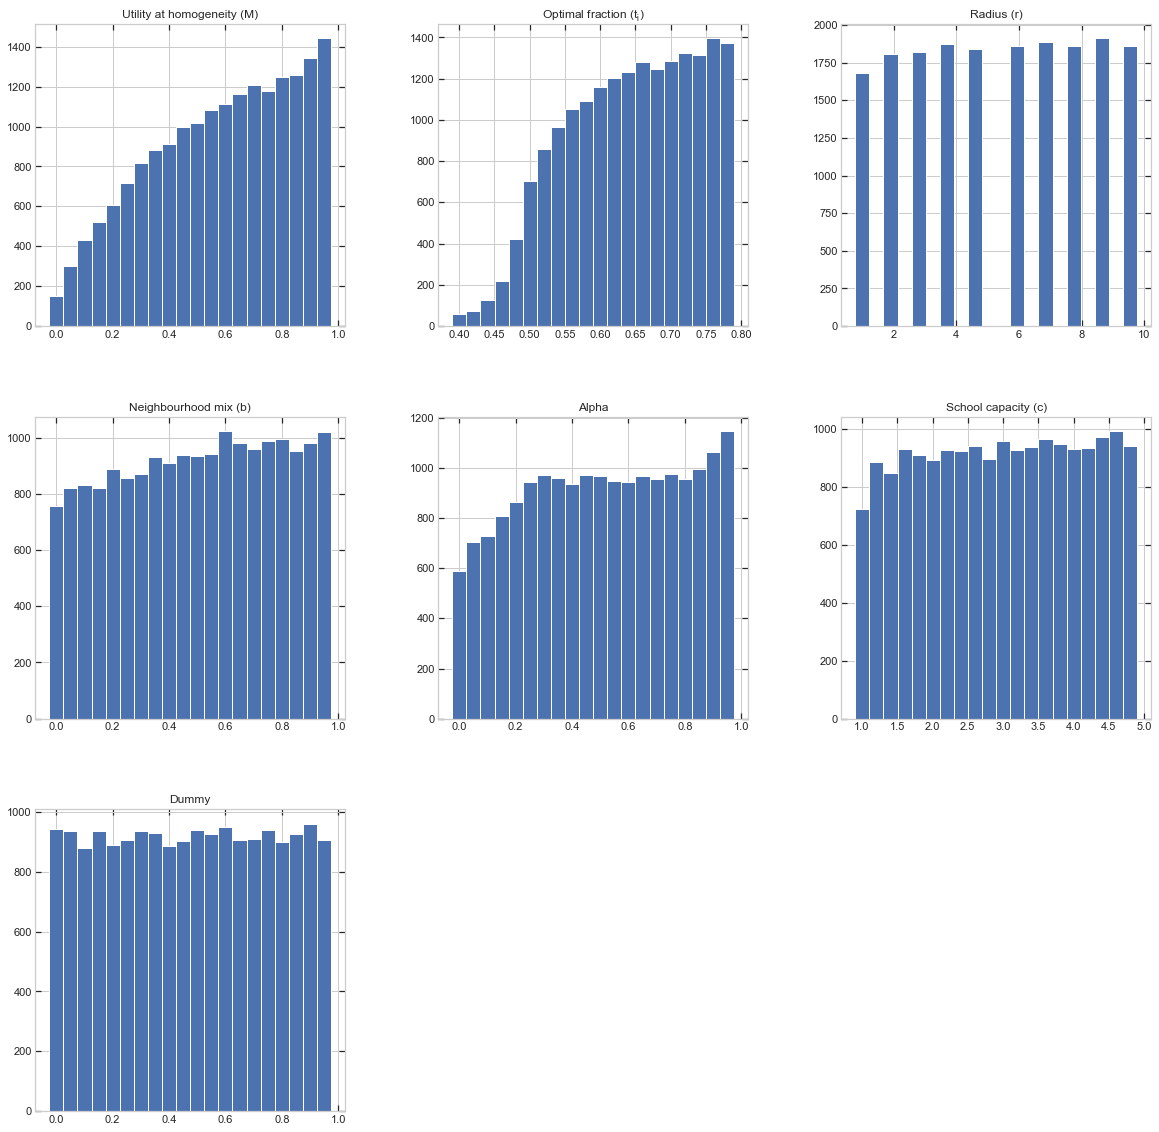

In [8]:
fully_res = parameters[data['School segregation (Theil)']>0.99]
_ = fully_res.hist(figsize=(20,20), align='left', bins=20)

In [9]:
class Sensitivity:
    
    def __init__(self, name, path, parameters, output):
        """
        This class is used to conduct several sensitivity analyses on 
        a specific dataset for now, but can be made more generic. 
    
            name (str): name of the experiment
            path (str): path to save outputs to
            parameters (DataFrame): DataFrame of all input parameters
            output (DataFrame): DataFrame of all output variables
        """
        self.name = name
        self.path = path
        self.parameters = parameters
        self.output = output
        self.plot_directory(name)
        
        
    def plot_directory(self, name):
        # Create directory if it does not exist yet.
        self.plot_path = f'../plots/{name}'
        
        if not os.path.exists(self.plot_path):
            os.makedirs(self.plot_path)
            
            
    def get_plot_directory(self):
        return self.plot_path
            
            
    def set_style(self, font_scale=1, style='white', figsize=(20,20), fontsize=20):
        # Sets the seaborn style
        mpl.rcParams['figure.figsize'] = figsize
        mpl.rcParams['font.size'] = fontsize
        
    def save_figure(self, plot_path, filename):
        # Save figure as pdf in the correct folder.
        # Create directory if it does not exist yet.
        today = date.today()
        _ = plt.savefig(f'{plot_path}/{filename}-{today.strftime("%d-%m-%Y")}.pdf')
       
    
    def descriptive(self):
        # Plots and saves histograms of the input and output
        output_columns = output.columns[[0,1,4]]
        _ = parameters.hist(figsize=(20,20), align='left', 
            bins=20, backend='matplotlib')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self.save_figure(self.plot_path, filename='parameter_distributions')
        _ = output.hist(figsize=(20,5), align='left', column=output_columns,
            bins=20, backend='matplotlib', layout=(1,len(output_columns)))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self.save_figure(self.plot_path, filename='output_distributions')
      
    
    def calc_sobol_indices(self, problem, calc_second_order=False, 
                      num_resamples=10, seed=3):
        """
        Calculates the first- and total order indices using the Sobol
        method. If calc_second_order=True, the second-order indices 
        are also calculated. Result is a dictionary from SALib. Note
        that the Sobol method requires Saltelli sampling and will throw
        an error otherwise.
        """
        self.sobol_indices = {}
        print('Calculating Sobol indices!')
        for name in self.output.columns:
            output_values = self.output[name].values
            indices = sobol.analyze(problem, output_values,
                        calc_second_order=calc_second_order,
                        num_resamples=num_resamples)
            self.sobol_indices[name] = indices
        print('Done!')
        
        
    def calc_delta_indices(self, problem, num_resamples=10, seed=3):
        """
        Calculates the first-order indices using the Sobol
        method and those of the Delta method. Result is a 
        dictionary from SALib.
        """
        self.delta_indices = {}
        input_values = self.parameters.values
        
        print('Calculating Delta indices!')
        for name in self.output.columns:
            output_values = self.output[name].values
            indices = delta.analyze(problem, input_values, 
                        output_values,
                        num_resamples=num_resamples)
            self.delta_indices[name] = indices
        print('Done!')
        
        
    def plot_pawn_cdfs(self):
        """
        Plots the unconditional and conditional cdfs the
        PAWN method uses for sensitivity calculations.
        """
        input_values = self.parameters
        
        X = input_values.values
        X_Labels = list(input_values.columns)
        n = [10]*X.shape[1] # number of conditioning intervals
#         n[2] = 9 # Needs to be smaller than 10 for some reason
        
        for name in self.output.columns:
            plt.rcParams["figure.figsize"] = (20,30)
            plt.tight_layout(rect=[0, 0.03, 1, 0.98])
            indices = {}
            Y = self.output[name].to_numpy()
            YF, FU, FC, xc = PAWN.pawn_plot_cdf(X, Y, n, cbar=True, n_col=3,
                                               labelinput=X_Labels, Y_Label=name)
            plt.suptitle(f'PAWN CDFs of {name}', fontsize=20)
            sensitivity.save_figure(self.plot_path, filename=f'cdfs-{name}')
            plt.show()

            
    def calc_pawn_indices(self, num_resamples):
        """
        Calculates the sensitivity indices using the PAWN
        method. Result is a transformed to a dictionary 
        similar to those from SALib for ease of plotting.
        """
        self.pawn_indices = {}
        input_values = self.parameters
        
        X = input_values.values
        X_Labels = list(input_values.columns)
        n = [10]*X.shape[1] # number of conditioning intervals
#         n[2] = 9 # Needs to be smaller than 10 for some reason
        
        print('Calculating PAWN indices!')
        for name in self.output.columns:
            indices = {}
            Y = self.output[name].to_numpy()

            KS_median, KS_mean, KS_max = PAWN.pawn_indices(X, Y, n, Nboot=num_resamples)
            KS_median_m, KS_median_lb, KS_median_ub = aggregate_boot(KS_median)
            indices['pawn_median'] = KS_median_m
            indices['pawn_median_lb'] = KS_median_m - KS_median_lb
            indices['pawn_median_ub'] = KS_median_ub - KS_median_m
            
            KS_mean_m, KS_mean_lb, KS_mean_ub = aggregate_boot(KS_mean) # shape (M,)
            indices['pawn_mean'] = KS_mean_m
            indices['pawn_mean_lb'] = KS_mean_m - KS_mean_lb
            indices['pawn_mean_ub'] = KS_mean_ub - KS_mean_m
            
            KS_max_m, KS_max_lb, KS_max_ub = aggregate_boot(KS_max) # shape (M,)
            indices['pawn_max'] = KS_max_m
            indices['pawn_max_lb'] = KS_max_m - KS_max_lb
            indices['pawn_max_ub'] = KS_max_ub - KS_max_m
            
            self.pawn_indices[name] = indices
            
        print('Done!')

        
    def plot_indices(self, methods, method_names):
        """
        Creates a plot of the supplied sensitivity indices for every 
        ouput variable. This shows how sensitive each output is to 
        that individual parameter.
        """        
        
        # Loop over all outputs
        for name in self.output.columns:
            
            plt.title(f'Global sensitivity of {name}')
            
            # Loop over the methods you want plotted
            markers = ('o', 'v', 's', 'd', '<', '+')
            colors = sns.color_palette()
            for index, method in enumerate(methods):
                

                if method=='S1':
                    means = self.sobol_indices[name][method]
                    errors = self.sobol_indices[name][method + '_conf']
                    
                elif method=='ST':
                    means = self.sobol_indices[name][method]
                    errors = self.sobol_indices[name][method + '_conf']
                    
                elif method=='delta':
                    means = self.delta_indices[name][method]
                    errors = self.delta_indices[name][method + '_conf']
                    
                elif method in ['pawn_mean', 'pawn_median', 'pawn_max']:
                    means = self.pawn_indices[name][method]
                    # Errors are calculated down because of sorting
                
                
                if index==0:
                    plt.ylim([-0.2, len(means) - 1 + 0.2])
                    # Sort on the first method in the list.
                    sorted_indices = np.argsort(means)
                    names = np.array(self.parameters.columns)[sorted_indices]
                
                # Check if errors are 1D or 2D array (asymmetric)
                if method not in ['pawn_mean', 'pawn_median', 'pawn_max']:
                    errors = errors[sorted_indices]
                else:
                    errors = np.array(
                        [self.pawn_indices[name][method + '_lb'][sorted_indices],
                        self.pawn_indices[name][method + '_ub'][sorted_indices]])
                
                
                plt.errorbar(means[sorted_indices], range(len(means)), 
                             xerr=errors, linestyle='None', 
                             marker=markers[index], color=colors[index])

#             plt.grid(b=True, which='major', axis='x', color='#666666', linestyle='-')
            plt.legend(method_names)
            plt.axvline(0, c='k')
            plt.yticks(range(len(means)), names)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            self.save_figure(self.plot_path, filename=f'sensitivity-{name}')
            plt.show()
    
    
    def calc_convergence(self, problem, calc_second_order, num_resamples, 
                             method_names, parameter_names):
        N = len(self.parameters)
        NN = np.linspace(N/5, N, 5).astype(int)
        list_of_frames = [0] * len(NN)
            
        for name in self.output.columns:
            
            for index, sample in tqdm(enumerate(NN)):
                output_values = self.output[name].values[:sample]
                indices = sobol.analyze(problem, output_values,
                            calc_second_order=calc_second_order, 
                            num_resamples=num_resamples)
                titles = [parameter_names[key] for key in problem['names']]
                indices['Parameter'] = titles
                
                if calc_second_order:
                    del indices['S2']
                    del indices['S2_conf']
                
                frame = pd.DataFrame(indices)
                frame['size'] = sample
                frame['output'] = name
            
                list_of_frames[index] = frame
            
            convergence = pd.concat(list_of_frames)
            self.plot_convergence(convergence, name, method_names)
    
    
    def plot_convergence(self, data, title, method_names):
        methods = ["S1", "ST"]
        cols = data.columns
        id_cols = cols.drop(methods)
        g = sns.relplot(data=data.melt(id_vars=id_cols, value_vars=methods),
                        x="size", y="value", hue="variable", style='variable', 
                        col="Parameter", kind="line", height=5, aspect=1, 
                        col_wrap=3, legend=False, markers=True, 
                        facet_kws={'sharex':False, 'sharey':False})

        for item in g.axes_dict.items():

            name = item[0]
            ax = item[1]
            filldata = data[data.Parameter==name]
            x = filldata['size']

            for method in methods:
                y1 = filldata[method] - filldata[method + '_conf']
                y2 = filldata[method] + filldata[method + '_conf']
                ax.fill_between(x, y1, y2, alpha=0.2)

            ax.set_xticks(x)
            ax.set_ylim([0, None])
        g.fig.suptitle(f'Convergence of sensitivity indices for {title}')
        g.set_titles(col_template="{col_name}", fontsize=18)
        g.set_axis_labels("Sample size", "Sensitivity index")
        g.add_legend(labels=method_names, loc='center',
                     bbox_to_anchor=(0.5, 0.93), ncol=2)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self.save_figure(self.plot_path, filename=f'sensitivity-convergence-{title}')
        plt.show()
    
        
    def plot_sobol_interactions(self, problem, parameter_names):

        for index, name in enumerate(self.output.columns):
            ax = plt.gca()
            sobol_indices = self.sobol_indices[name]
            vmin = np.nanmin(sobol_indices['S2'])
            vmax = np.nanmax(sobol_indices['S2'])

            figure = sns.heatmap(data=sobol_indices['S2'], annot=sobol_indices['S2_conf'], 
                                 fmt='.2f', annot_kws={'size':12},
                                cmap='viridis', cbar=False, ax=ax)
            for t in figure.texts: t.set_text("\n\n(" + t.get_text() + ")")
            figure2 = sns.heatmap(data=sobol_indices['S2'], annot=True, 
                                  fmt='.2f', annot_kws={'size':12},
                                cmap='viridis', vmin=vmin, vmax=vmax, cbar=True, ax=ax)
            ax.set_title(name)
            figure2.invert_yaxis()
            titles = [parameter_names[key] for key in problem['names']]
            ax.set_xticklabels(titles, rotation=90)
            ax.set_yticklabels(titles, rotation=0)
            plt.title(f'Sobol second-order interactions {name}')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            self.save_figure(self.plot_path, filename=f'sobol-second-order-{name}')
            plt.show()
    
sensitivity = Sensitivity(experiment_name, path, parameters, output)

In [1]:
# %%capture --no-display
sensitivity.plot_pawn_cdfs()

NameError: name 'sensitivity' is not defined

In [10]:
# Plot the distribution of the input parameters and output variables
plt.rc('figure', figsize=(10,5))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
# sensitivity.descriptive()

In [11]:
num_resamples = 100
calc_second_order = True
problem = pd.read_pickle(f"{path}problem.pickle")

# Calculate indices
sensitivity.calc_sobol_indices(problem, 
                               calc_second_order=calc_second_order, 
                               num_resamples=num_resamples)
sensitivity.calc_pawn_indices(num_resamples=num_resamples)
sensitivity.calc_delta_indices(problem, num_resamples=num_resamples)

Calculating Sobol indices!
Done!
Calculating PAWN indices!


C:\Users\edignum\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\SAFEpython\util.py:24: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "empiricalcdf" failed type inference due to: Use of unsupported NumPy function 'numpy.ndarray' or unsupported use of the function.

File "..\..\..\..\..\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\SAFEpython\util.py", line 72:
def empiricalcdf(x, xi):
    <source elided>
    ###########################################################################
    if not isinstance(x, np.ndarray):
    ^

During: typing of get attribute at C:\Users\edignum\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\SAFEpython\util.py (72)

File "..\..\..\..\..\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\SAFEpython\util.py", line 72:
def empiricalcdf(x, xi):
    <source elided>
    ###########################################################################
    if not isinstance(x, np.ndarra

Done!
Calculating Delta indices!
Done!


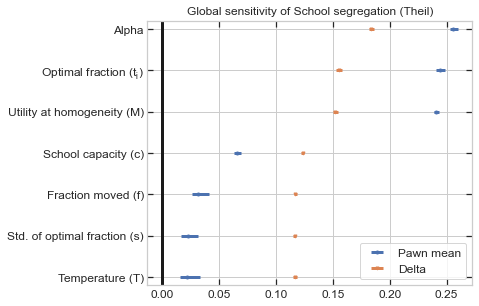

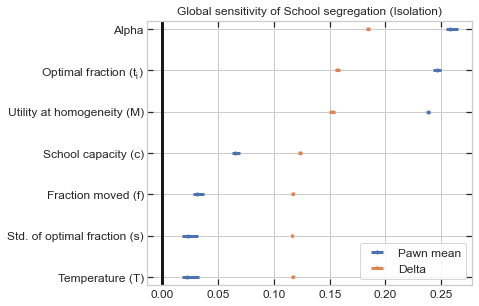

In [17]:
plt.rc('figure', figsize=(7,5))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('markersize')
methods = ['pawn_mean', 'delta'] #['S1', 'ST', 'pawn_mean', 'delta']
method_names = ['Pawn mean', 'Delta'] #['Sobol first-order', 'Sobol total-order', 'Pawn mean', 'Delta']
sensitivity.plot_indices(methods, method_names)

In [13]:
plt.rc('figure', figsize=(10,10))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
method_names = ['Sobol first-order', 'Sobol total-order']
# sensitivity.calc_convergence(problem, 
#                              calc_second_order=calc_second_order, 
#                              num_resamples=num_resamples,
#                              method_names=method_names,
#                              parameter_names=renaming)

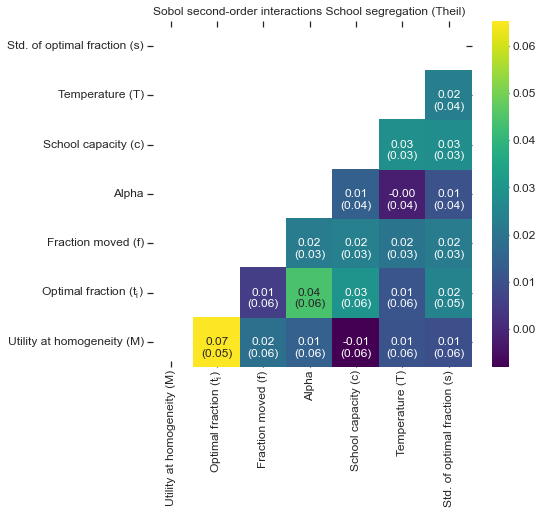

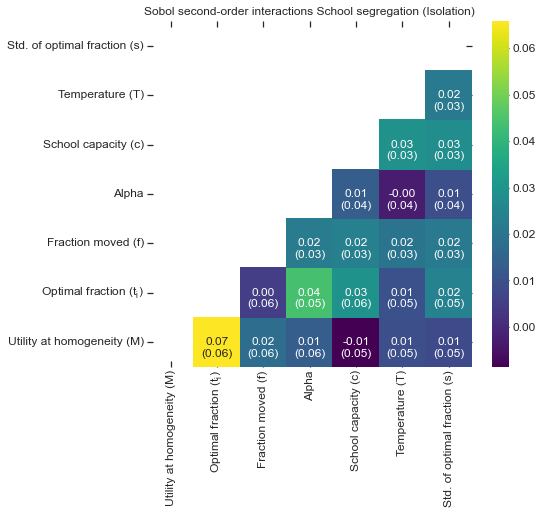

In [14]:
plt.rc('figure', figsize=(8,8))
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
sensitivity.plot_sobol_interactions(problem, renaming)

# Interactions

<Figure size 1080x360 with 0 Axes>

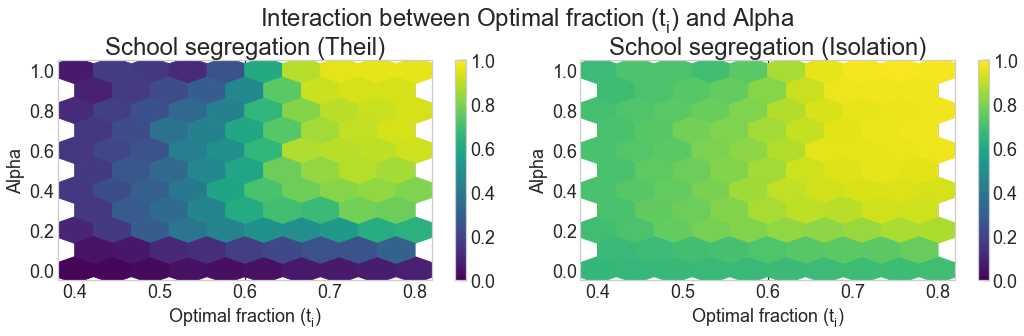

<Figure size 1080x360 with 0 Axes>

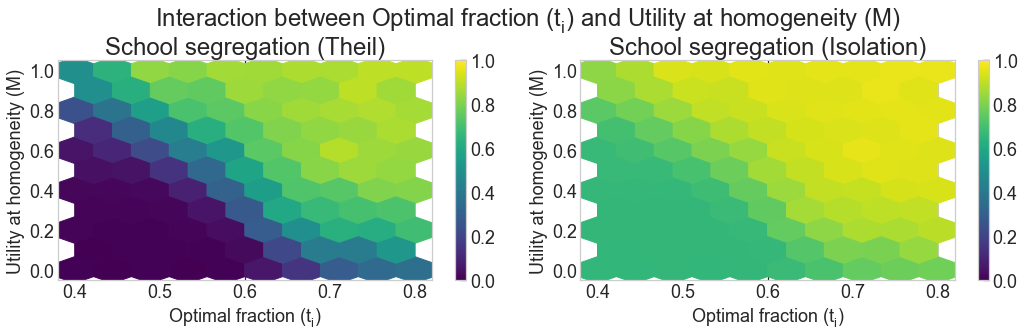

<Figure size 1080x360 with 0 Axes>

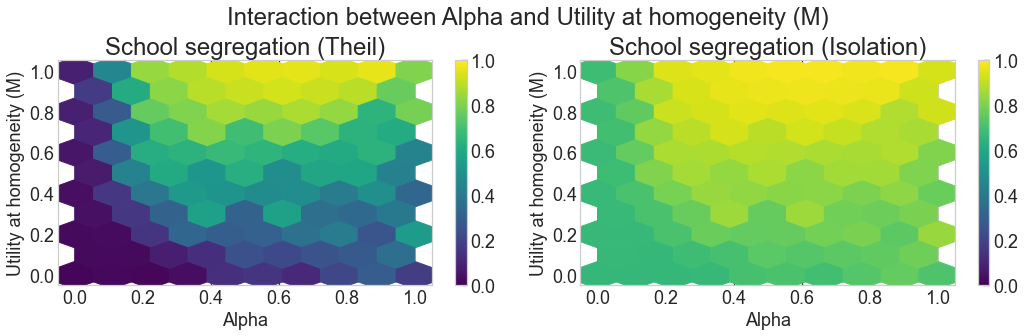

In [15]:
subset = [names[name] for name in ['single_optimal_fraction', 
            'alpha', 'single_utility_at_max']]
interactions = combinations(subset, 2)
plot_path = f'../plots/{experiment_name}'
vmax = max([data[outcome].max() for outcome in output.columns])

plt.rc('figure', figsize=(15,5), titlesize=24)
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize

for name in interactions:
    _ = plt.figure()
    fig, axs = plt.subplots(1, 2)
    axs = axs.flatten()
    for index, outcome in enumerate(output.columns[:2]):
        data.plot.hexbin(
            x=name[0], y=name[1], C=outcome, gridsize=9, cmap='viridis', 
            vmin=0, vmax=vmax, ax=axs[index], title=outcome)
    plt.suptitle(f'Interaction between {name[0]} and {name[1]}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])   
    sensitivity.save_figure(plot_path, filename=f'sensitivity-interaction-{name[0]}-{name[1]}')
    plt.show()

# Average effects

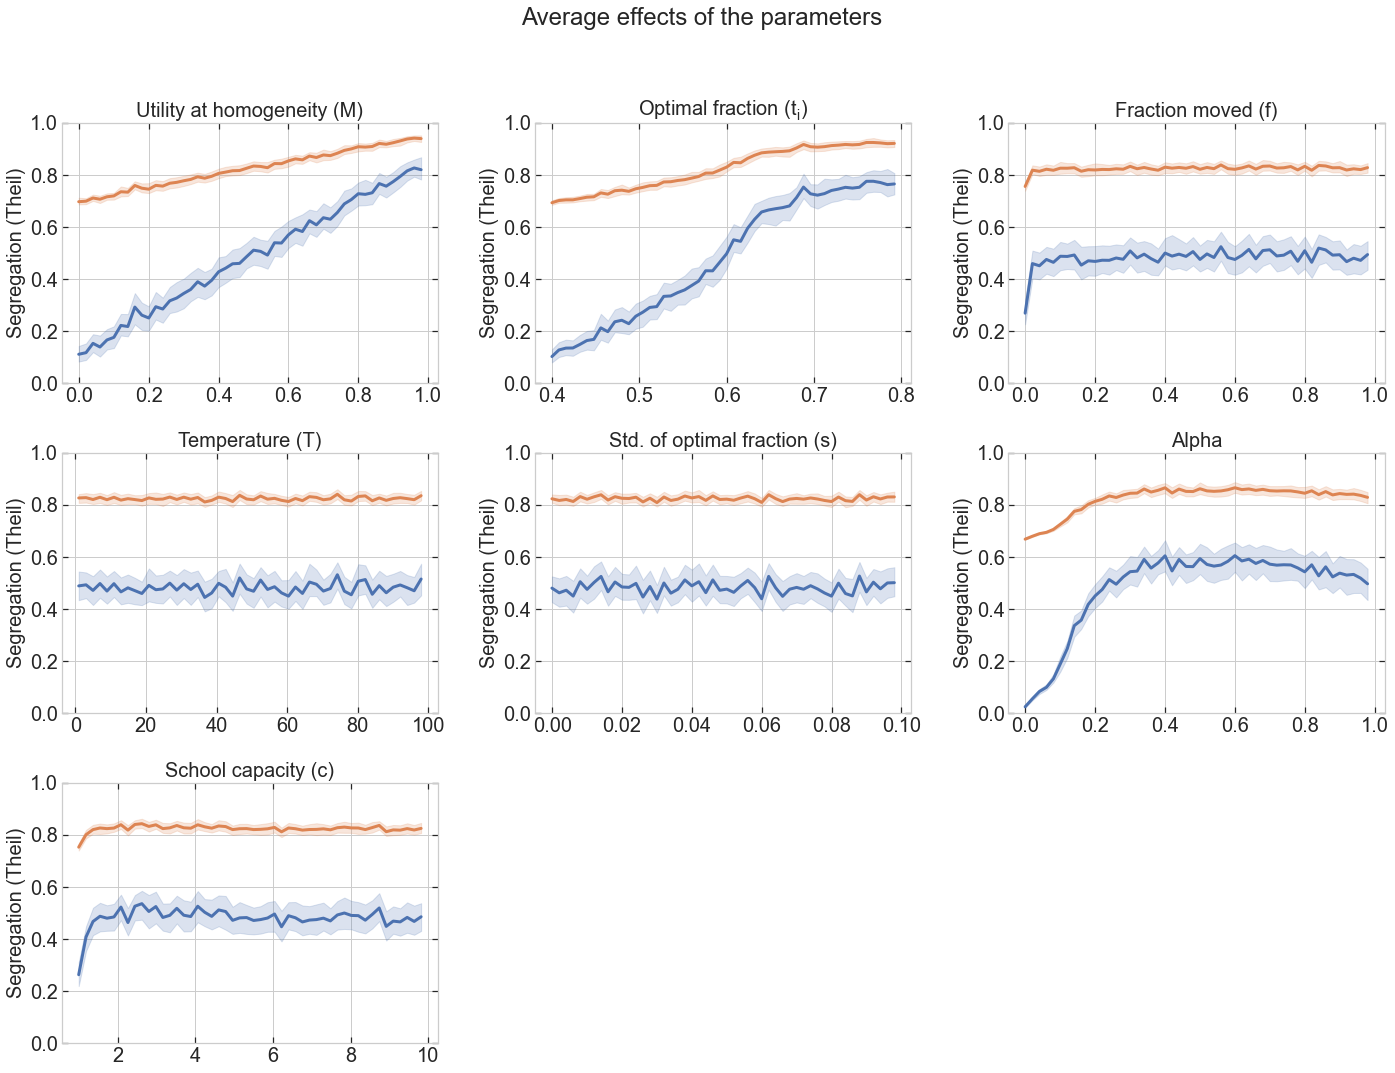

In [16]:
plt.rc('figure', titlesize=24)
plt.rc('font', size=24)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

def plot_avg_effect(data, variables, y, bins, 
                    n_rows, n_cols, figsize):
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Average effects of the parameters')
    
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        intervals = pd.cut(data[var_name], bins=bins)
        left_values = pd.IntervalIndex(intervals).left
        
        if len(y)==1:
            y_values = data[y]
            sns.lineplot(x=left_values, y=y_values, ax=ax, marker=markers[i])
        else:
            for y_var in y:
                y_values = data[y_var]
                sns.lineplot(x=left_values, y=y_values, ax=ax, ci=100)
                
        ax.set_title(var_name)
        ax.set_ylabel('Segregation (Theil)')
        plt.ylim(0, 1)
    
    fig.legend(labels=y, ncol=3, bbox_to_anchor=(0.8, 0.95))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Improves appearance a bit.
    
plot_avg_effect(data, parameters.columns, y=output.columns, 
             bins=50, n_rows=6, n_cols=3, figsize=(20,30))
sensitivity.save_figure(plot_path, filename=f'average-effects')
plt.show()